# Activation Maximization

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
if tf.__version__ == '2.0.0':
    print("Num GPUs Available: ", len(tf.experimental.config.list_physical_devices('GPU')))
else:
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Load tf.keras.Model and Define modifier

This tutorial use VGG16 model in tf.keras but if you want to use other tf.keras.Models, you can do so by modifing section below.

In [2]:
# Load model
from tensorflow.keras.applications.vgg16 import VGG16 as Model

model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Visualizing a specific output category

ActivationMaximization will maximize the value that is computed by the loss function that is passed as argument. Here, we try to visualize a category as defined No.20 (ouzel) of imagenet.

> [!NOTE]
> The softmax activation function which is applied to model's last layer may obstruct generating shape images, so that you need to replace the function to a linear function using `model_modifier`.

Steps: 100	Losses: [137.38502502441406],	Regularizations: [[('TotalVariation', 93.0440902709961), ('L2Norm', 0.025591570883989334)]]
Steps: 200	Losses: [158.2390594482422],	Regularizations: [[('TotalVariation', 93.271240234375), ('L2Norm', 0.025500230491161346)]]


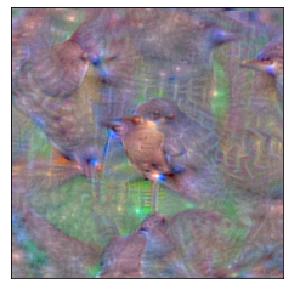

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow.keras import backend as K
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.callbacks import Print

# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Create Activation Maximization object
activation_maximization = ActivationMaximization(model, model_modifier)

# Define loss function. 20 is the imagenet index corresponding to ouzel.
loss = lambda x: K.mean(x[:, 20])

# Generate max activation with debug printing
activation = activation_maximization(loss, callbacks=[Print(interval=100)])
image = activation[0].astype(np.uint8)

f, ax = plt.subplots(figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)
plt.show()

Let's see if we can get better results with more iterations.

Steps: 100	Losses: [152.96820068359375],	Regularizations: [[('TotalVariation', 92.47662353515625), ('L2Norm', 0.025599589571356773)]]
Steps: 200	Losses: [229.22866821289062],	Regularizations: [[('TotalVariation', 95.95075988769531), ('L2Norm', 0.02547534555196762)]]
Steps: 300	Losses: [248.43057250976562],	Regularizations: [[('TotalVariation', 99.64918518066406), ('L2Norm', 0.025354132056236267)]]
Steps: 400	Losses: [286.50830078125],	Regularizations: [[('TotalVariation', 106.73420715332031), ('L2Norm', 0.02523781731724739)]]
Steps: 500	Losses: [302.614990234375],	Regularizations: [[('TotalVariation', 108.40864562988281), ('L2Norm', 0.025139635428786278)]]


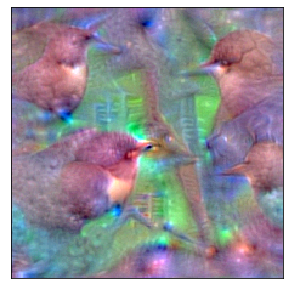

In [4]:
from tf_keras_vis.utils.callbacks import GifGenerator

# Do 500 iterations and Generate an optimizing animation
activation = activation_maximization(loss,
                                     steps=512,
                                     callbacks=[ Print(interval=100),
                                                 GifGenerator('images/activation_maximization')])
image = activation[0].astype(np.uint8)

f, ax = plt.subplots(figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)
plt.show()

The animation gif is below. We can see the vision that was constructed the input that was being maximized.

In [5]:
from IPython.display import HTML
HTML('<img src="./images/activation_maximization.0.gif">')

### Visualizing Conv filters

You can also visualize conv filter if you replace the model output to target layer's output. For visualizing these filters clearly and sharply, we recommend you using `SmoothingLoss`. Most of conv filters will be visualized well.

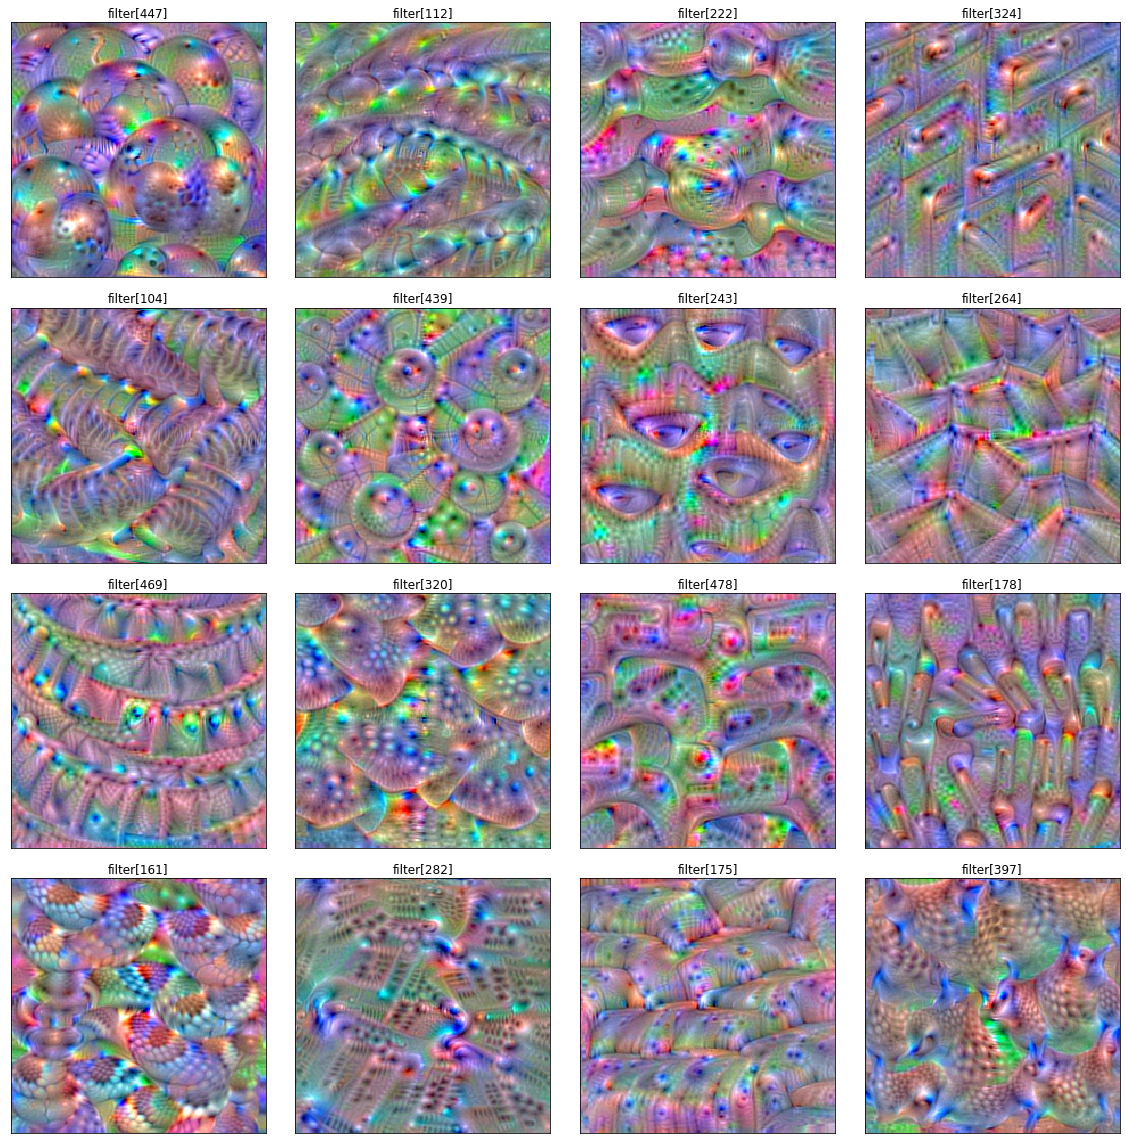

In [7]:
from tensorflow.keras import backend as K
from tf_keras_vis.utils.losses import SmoothingLoss

# The target layer that is the last layer of VGG16.
layer_name = 'block5_conv3'

# Define modifier to replace the model output to target layer's output.
# You need to return new model when you create new model instance in model_modifier.
def model_modifier(m):
    new_model = tf.keras.Model(inputs=m.inputs, outputs=[m.get_layer(name=layer_name).output])
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

# Create Activation Maximization object
activation_maximization = ActivationMaximization(model, model_modifier)

num_of_filters = 16
filter_numbers = np.random.choice(model.get_layer(name=layer_name).output.shape[-1], num_of_filters)
cols = 4
rows = num_of_filters // cols
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 4, rows * 4), subplot_kw={'xticks': [], 'yticks': []})

for i, filter_number in enumerate(filter_numbers):
    # Define loss function that is sum of a filter output.
    loss = SmoothingLoss(filter_number)

    # Generate max activation with debug printing
    activation = activation_maximization(loss)
    image = activation[0].astype(np.uint8)

    ax[i // cols][i % cols].imshow(image)
    ax[i // cols][i % cols].set_title('filter[{:03d}]'.format(filter_number))

plt.tight_layout()
plt.show()